In [78]:
import pandas as pd
import numpy as np
import warnings
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## - Import some functions to reduce the size of the notebooks

In [79]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import *

In [80]:
df = pd.read_csv('../../../Iquitos_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [81]:
nb_variables = {'window': 5, 'shift': -3, 'drop_threshold': 0.05}

In [82]:
print('------ Basic Stats about the Iquitos Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the Iquitos Training set ------ 

- Number of rows of the training set: 520 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.4% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [83]:
df = fill_values(df, nb_variables['window'], give_info = True)

Filling NA values with the running mean of 4 previous values (window = 5) 

- The amount of NAs was reduced to 0.07% 

- For the next step we will fill the remaining NAs with zeroes 

Filling NA values with 0 

- The amount of NAs was reduced to 0.0% 

- No more NA values left 



In [84]:
# correlations = df.corr()
# (correlations
#      .total_cases
#      .drop('total_cases')
#      .sort_values(ascending=False)
#      .plot
#      .barh())

In [85]:
drop_cols(df, nb_variables['drop_threshold'])

array(['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'station_diur_temp_rng_c', 'station_precip_mm'], dtype=object)

In [86]:
df.drop(drop_cols(df, nb_variables['drop_threshold']), axis = 1, inplace = True)

In [87]:
df, mask = generate_anomalies(df, 0.15)

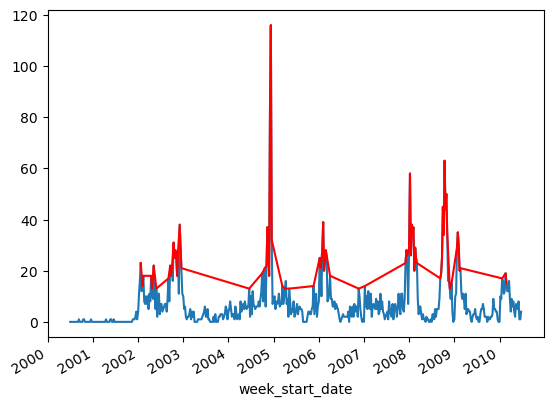

In [88]:
df['total_cases'].plot()
df.iloc[mask, :]['total_cases'].plot(color = 'red')
plt.show()

# - Turn the problem into a supervised one

In [89]:
new_df = n_step_shift(df, nb_variables['shift'])

In [90]:
new_df.shape

(517, 61)

In [113]:
train_amount = 0.6
cutoff = int(train_amount * len(df))

# Unshifted Datasets
un_x_train = df.iloc[:cutoff, 1: -2]
un_x_test = df.iloc[cutoff:, 1: -2]

un_y_train = df.iloc[:cutoff, -2:]
un_y_test = df.iloc[cutoff:, -2:]


# Shifted Datasets
df_x_train = new_df.iloc[:cutoff, : -1]
df_x_test = new_df.iloc[cutoff:, : -1]

df_y_train = new_df.iloc[:cutoff, -1:]
df_y_test = new_df.iloc[cutoff:, -1:]

In [114]:
un_x_train, un_y_train, un_x_test, un_y_test, mask1, mask2, anomaly_detector = anomaly_detector_training(un_x_train, un_y_train, 
                                                                                                         un_x_test, un_y_test, 
                                                                                                         n_estimators = 20, 
                                                                                                         max_depth = 4,
                                                                                                         learning_rate = 0.1)

Train anomalies: 43 Train predicted anomalies: 42
Train Anomalies in common: 30
Train F1 Score: 0.706 

Test anomalies: 34 Test predicted anomalies: 29
Test Anomalies in common: 5
Test F1 Score: 0.159


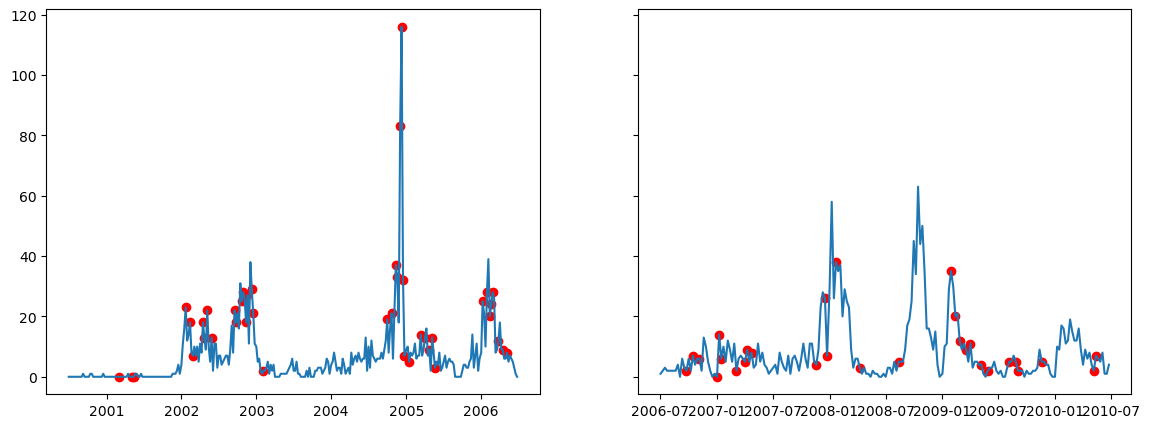

In [115]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (14, 5))
axs[0].plot(un_y_train['total_cases'])
axs[0].scatter(x = un_y_train.iloc[mask1, :]['total_cases'].index, 
               y = un_y_train.iloc[mask1, :]['total_cases'].values,
               color = 'red')

axs[1].plot(un_y_test['total_cases'])
axs[1].scatter(x = un_y_test.iloc[mask2, :]['total_cases'].index, 
               y = un_y_test.iloc[mask2, :]['total_cases'].values,
               color = 'red')
plt.show()

In [116]:
new_x_train = un_x_train[un_x_train['predicted_anomaly'] == 1].drop('predicted_anomaly', axis = 1)
new_y_train = un_y_train[un_y_train['predicted_anomaly'] == 1].iloc[:,0]

new_x_test = un_x_test[un_x_test['predicted_anomaly'] == 1].drop('predicted_anomaly', axis = 1)
new_y_test = un_y_test[un_y_test['predicted_anomaly'] == 1].iloc[:,0]

In [128]:
anomaly_reg = anomaly_regressor_training(new_x_train, new_y_train, new_x_test, new_y_test, n_estimators = 20, 
                                         max_depth = 4, learning_rate = 0.1)

Train MAE: 10.429
Test MAE: 12.655


In [131]:
# Shift the anomalies columns
shift = np.abs(nb_variables['shift']).astype('int32')
train_shifted_anomalies = pd.concat([un_y_train['predicted_anomaly'][shift:], 
                                     un_y_test['predicted_anomaly'][:shift]], 
                                    axis=0)
train_shifted_anomalies.index = df_x_train.index

test_shifted_anomalies = un_y_test['predicted_anomaly'][shift:]
test_shifted_anomalies.index = df_x_test.index

In [132]:
assert len(train_shifted_anomalies) == len(df_x_train)
assert len(test_shifted_anomalies) == len(df_x_test)

In [133]:
df_x_train = pd.concat([df_x_train, train_shifted_anomalies], axis = 1)
df_x_test = pd.concat([df_x_test, test_shifted_anomalies], axis = 1)

In [134]:
with mlflow.start_run():
    model_1 = XGBRegressor(n_estimators = 20, booster = 'gbtree', subsample = 1, tree_method = 'exact',
                           objective = 'reg:absoluteerror', max_depth = 4, learning_rate = 1, 
                           nthread = 4, gamma = 0, random_state = 50)
    # Fit model
    model_1.fit(df_x_train.iloc[:,:-1], df_y_train)
    
    # Get MAE on Train and Test sets
    train_preds = predictions(model_1, anomaly_reg, df_x_train)
    test_preds = predictions(model_1, anomaly_reg, df_x_test)
    
    train_mae = np.round(np.mean(np.abs(train_preds - df_y_train.values)), 3)
    test_mae = np.round(np.mean(np.abs(test_preds - df_y_test.values)), 3)
    # --------------- Logging --------------- #
    mlflow.log_param('Window', nb_variables['window'])
    mlflow.log_param('Shift', nb_variables['shift'])
    mlflow.log_param('Train amount', train_amount)
    mlflow.log_param('Drop Threshold', nb_variables['drop_threshold'])
    mlflow.log_param('Booster', model_1.booster)
    mlflow.log_param('Number of Estimators', model_1.n_estimators)
    mlflow.log_param('Max Depth', model_1.max_depth)
    mlflow.log_param('Gamma', model_1.gamma)
    mlflow.log_param('Learning Rate', model_1.learning_rate)
    
    mlflow.log_metric('Train MAE', train_mae)
    mlflow.log_metric('Test MAE', test_mae)
    
    mlflow.sklearn.log_model(model_1, 'XGBoostRegressor')
    # --------------- Logging --------------- #
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (14, 5))

    train_title = (f'Train MAE: {train_mae} \n', 
                   f'Train Target Mean: {np.round(df_y_train.values.mean(), 3)}', 
                   f'Predictions Mean: {np.round(np.mean(train_preds), 3)}')
    axs[0].set_title('\n'.join(train_title))
    axs[0].plot(df_y_train)
    axs[0].plot(df_y_train.index, train_preds)

    test_title = (f'Test MAE: {test_mae} \n', 
                  f'Test Target Mean: {np.round(df_y_test.values.mean(), 3)}', 
                  f'Predictions Mean: {np.round(np.mean(test_preds), 3)}')
    axs[1].set_title('\n'.join(test_title))
    axs[1].plot(df_y_test)
    axs[1].plot(df_y_test.index, test_preds)
    
    plt.savefig('predictions_viz.png')
    
    mlflow.log_artifact('predictions_viz.png')
    
    plt.show()

ValueError: Feature shape mismatch, expected: 14, got 13

In [26]:
# pickle.dump(model_1, open('../models/sj_XGBoost', "wb"))